## Wrapper function

In [1]:
### Plot the relationship between categorical variable and target variable
def plot_cat_tar_relationship(df, x, y):
    pd.crosstab(df[x], df[y]).apply(lambda x: x/np.sum(x), axis=1).plot(kind='bar', stacked=True,
                                                                                            rot=0, edgecolor=None, color=
                                                                       ['gray', 'red'])
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel('Percentage')
    plt.title('The Distribution of '+x+' by '+y, y=1.02)

## Setup

In [2]:
### Load required packages 
import numpy as np 
import pandas as pd 
import scipy as sp
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True) 
import warnings
warnings.filterwarnings('ignore')

seed = 100
np.random.seed(seed)

In [3]:
### load the dataset
df = pd.read_csv('D:/Dataset/Side_project_Synthetic_fraud_detection/PS_20174392719_1491204439457_log.csv')

In [4]:
df.shape

(6362620, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [8]:
df['isFraud'].value_counts()/len(df)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

The distribution of the target variable is very imbalanced.

In [9]:
df['isFlaggedFraud'].value_counts()/len(df)

0    0.999997
1    0.000003
Name: isFlaggedFraud, dtype: float64

In [10]:
pd.crosstab(df['isFraud'], df['isFlaggedFraud'])

isFlaggedFraud,0,1
isFraud,,
0,6354407,0
1,8197,16


In [11]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(df['isFraud'], df['isFlaggedFraud'])

(array([ 0.99871169,  1.        ]),
 array([ 1.        ,  0.00194813]),
 array([ 0.99935543,  0.00388869]),
 array([6354407,    8213], dtype=int64))

The benchmark doesn't perform well.

#### For efficiency, I would like to use only 10% of the original dataset for exploratory data analysis firtst

In [12]:
from sklearn.model_selection import train_test_split

df_ex, _ = train_test_split(df, train_size=0.1, stratify=df['isFraud'], random_state=seed)

In [13]:
df_ex.index = range(len(df_ex))

In [14]:
df_ex['isFraud'].value_counts()

0    635441
1       821
Name: isFraud, dtype: int64

In [15]:
df_ex['isFraud'].value_counts()/len(df_ex)

0    0.99871
1    0.00129
Name: isFraud, dtype: float64

## EDA and Feature Engineering

In [16]:
### Transaction type
df_ex['type'].value_counts()

CASH_OUT    223306
PAYMENT     215332
CASH_IN     140132
TRANSFER     53325
DEBIT         4167
Name: type, dtype: int64

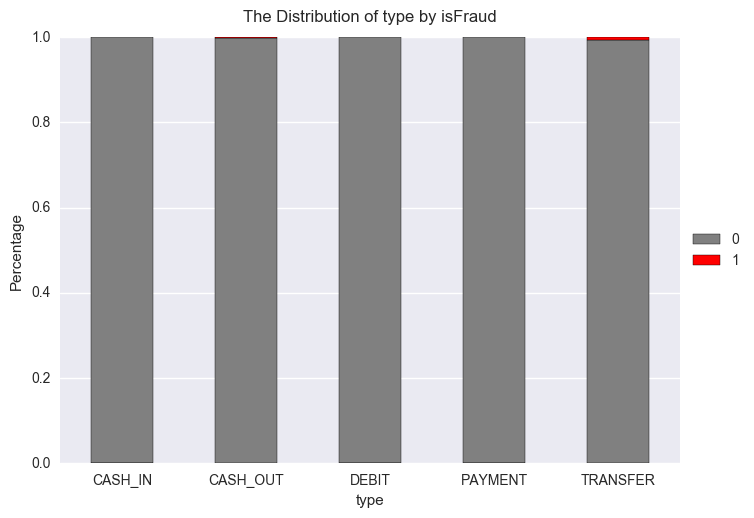

In [17]:
plot_cat_tar_relationship(df_ex, 'type', 'isFraud')

It seems that only transactions of CASH_OUT and TRANSFER are related to fraud.

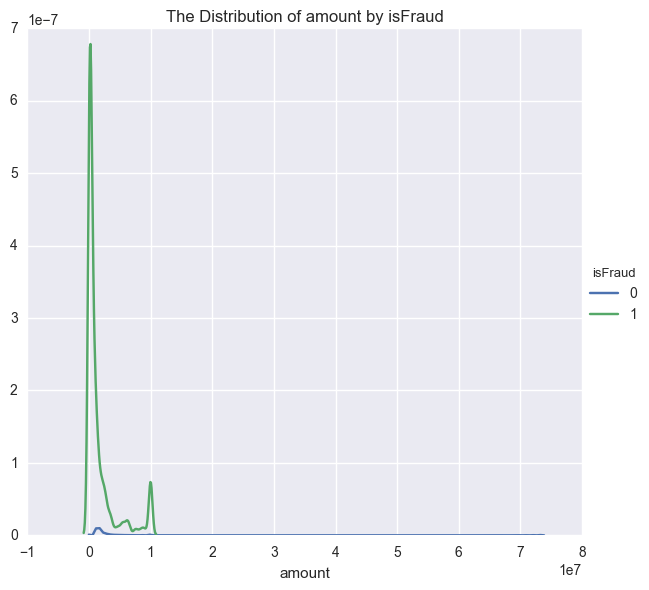

In [18]:
### Transaction amount
sns.FacetGrid(df_ex, hue='isFraud', size=6).map(sns.kdeplot, 'amount').add_legend()
plt.title('The Distribution of amount by isFraud')

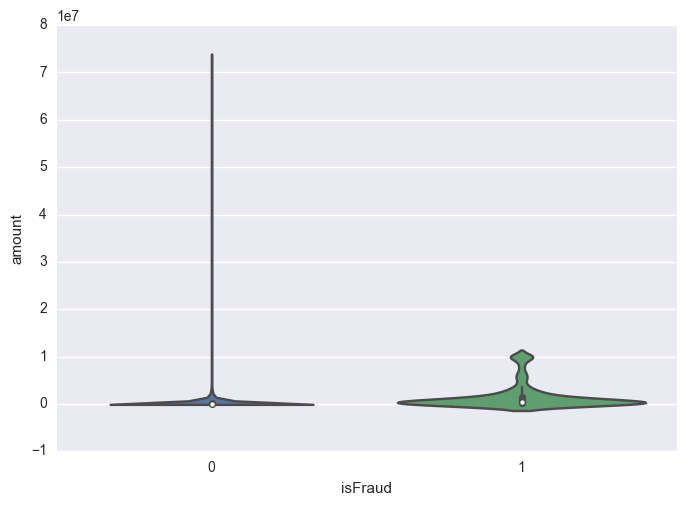

In [19]:
sns.violinplot(x='isFraud', y='amount', data=df_ex, size=6)

In [20]:
df_ex['log_amount'] = df_ex['amount'].apply(lambda x: np.log1p(x))

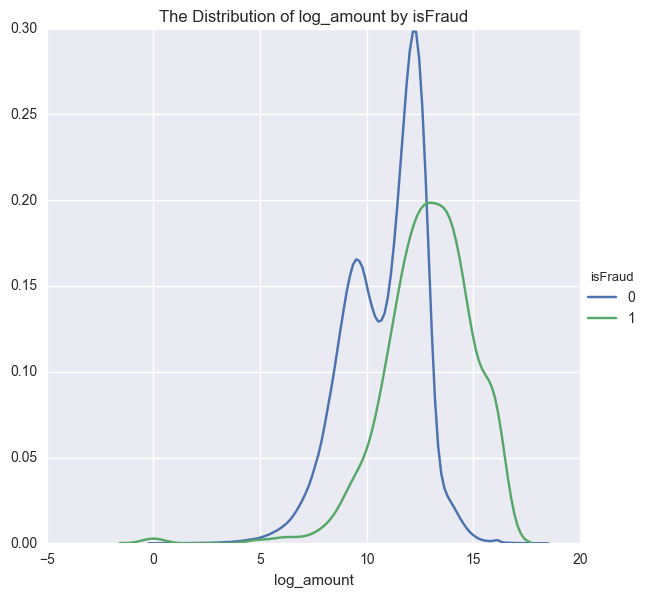

In [21]:
sns.FacetGrid(df_ex, hue='isFraud', size=6).map(sns.kdeplot, 'log_amount').add_legend()
plt.title('The Distribution of log_amount by isFraud')

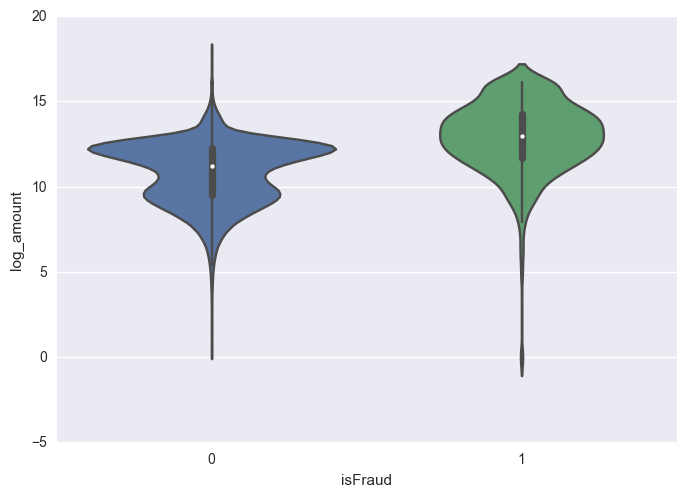

In [22]:
sns.violinplot(x='isFraud', y='log_amount', data=df_ex, size=6)

The log_amount looks like a better feature than the original amount

11    339937
10    266505
9      26730
8       2754
7        301
6         31
5          4
Name: nameOrig, dtype: int64


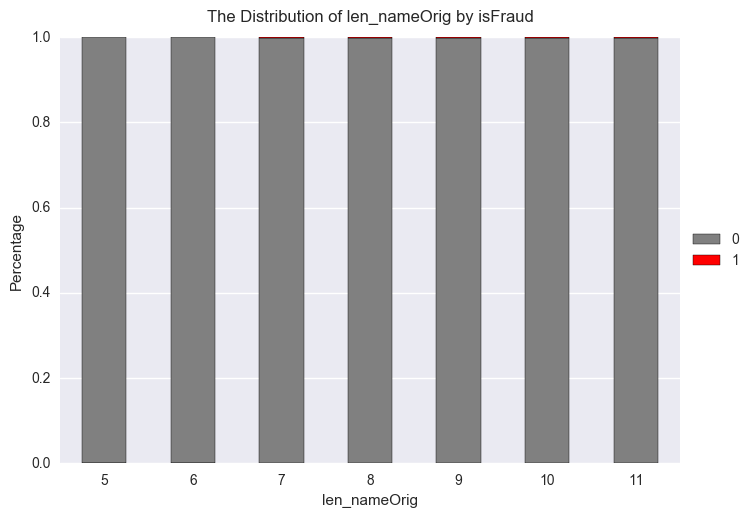

In [23]:
### customer nameOrig

## the distribution of length of name
print(df_ex['nameOrig'].apply(lambda x: len(x)).value_counts())
df_ex['len_nameOrig'] = df_ex['nameOrig'].apply(lambda x: len(x))

plot_cat_tar_relationship(df_ex, 'len_nameOrig', 'isFraud')

In [24]:
## the distribution of the first character of the name
print(df_ex['nameOrig'].apply(lambda x: x[0]).value_counts())

C    636262
Name: nameOrig, dtype: int64


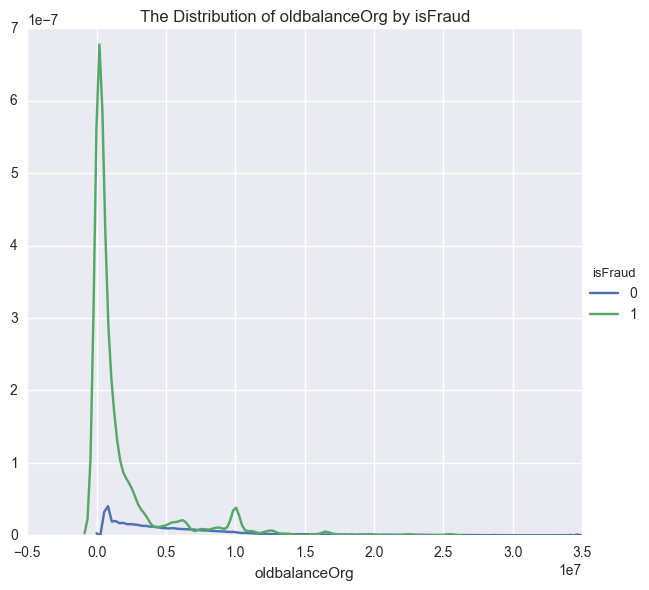

In [25]:
### balance
sns.FacetGrid(df_ex, hue='isFraud', size=6).map(sns.kdeplot, 'oldbalanceOrg').add_legend()
plt.title('The Distribution of oldbalanceOrg by isFraud')

In [26]:
df_ex['log_oldbalanceOrg'] = df_ex['oldbalanceOrg'].apply(lambda x: np.log1p(x))

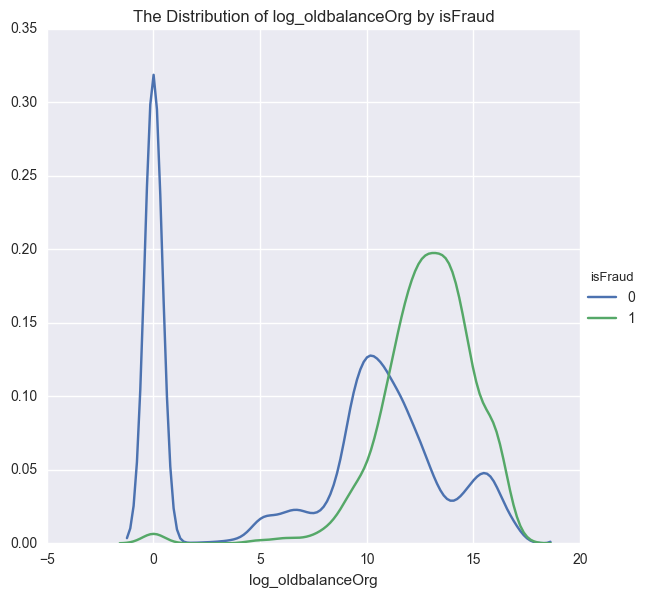

In [27]:
sns.FacetGrid(df_ex, hue='isFraud', size=6).map(sns.kdeplot, 'log_oldbalanceOrg').add_legend()
plt.title('The Distribution of log_oldbalanceOrg by isFraud')

The log-transformed balance data is better.

In [28]:
### nameDest

## the distribution of the first character of the nameDest
print(df_ex['nameDest'].apply(lambda x: x[0]).value_counts())

C    420930
M    215332
Name: nameDest, dtype: int64


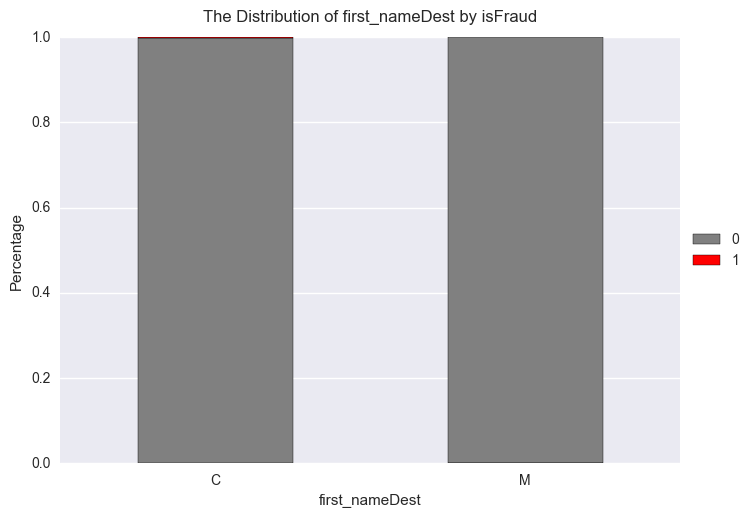

In [29]:
df_ex['first_nameDest'] = df_ex['nameDest'].apply(lambda x: x[0])
plot_cat_tar_relationship(df_ex, 'first_nameDest', 'isFraud')

In [30]:
pd.crosstab(df_ex['first_nameDest'], df_ex['isFraud']).apply(lambda x: x/np.sum(x), axis=1)

isFraud,0,1
first_nameDest,,
C,0.99805,0.00195
M,1.00000,0.00000


Only when the recipient's name starts with 'C', the transaction would be fraudulent.

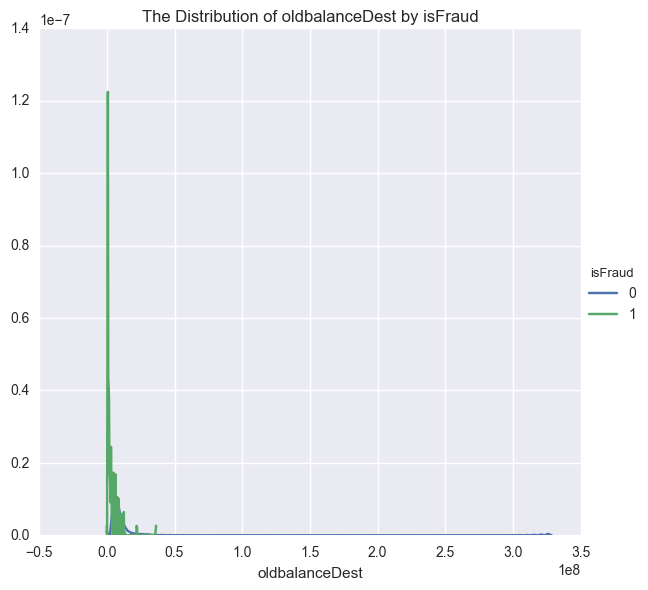

In [31]:
### oldbalanceDest (only for the nameDest starting with C)
df_ex_c = df_ex.ix[df_ex['nameDest'].apply(lambda x: x[0]) == 'C', :]
sns.FacetGrid(df_ex_c, hue='isFraud', size=6).map(sns.kdeplot, 'oldbalanceDest').add_legend()
plt.title('The Distribution of oldbalanceDest by isFraud')

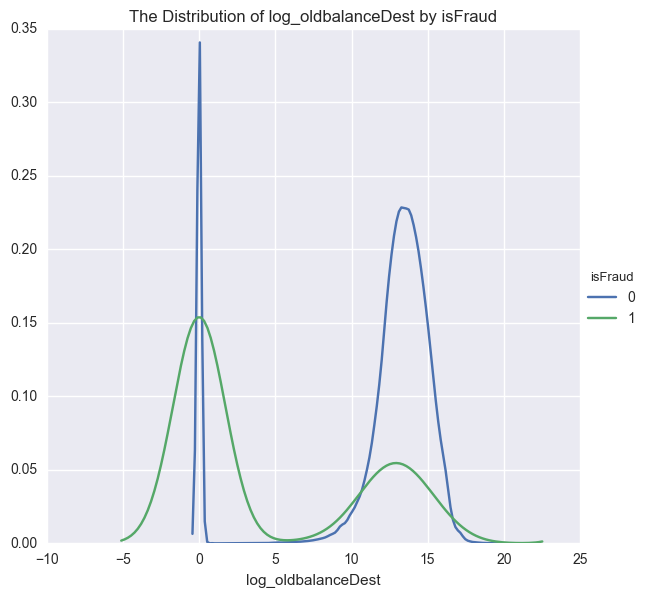

In [32]:
df_ex['log_oldbalanceDest'] = df_ex['oldbalanceDest'].apply(lambda x: np.log1p(x))

df_ex_c = df_ex.ix[df_ex['nameDest'].apply(lambda x: x[0]) == 'C', :]
sns.FacetGrid(df_ex_c, hue='isFraud', size=6).map(sns.kdeplot, 'log_oldbalanceDest').add_legend()
plt.title('The Distribution of log_oldbalanceDest by isFraud')

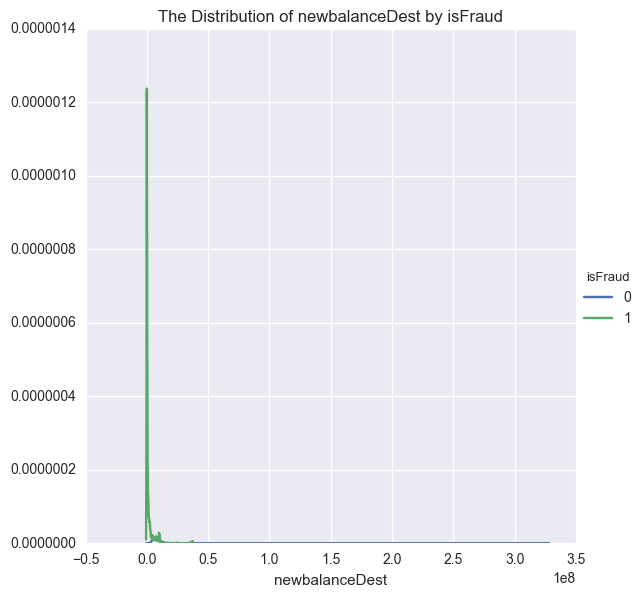

In [33]:
### newbalanceDest (only for the nameDest starting with C)
df_ex_c = df_ex.ix[df_ex['nameDest'].apply(lambda x: x[0]) == 'C', :]
sns.FacetGrid(df_ex_c, hue='isFraud', size=6).map(sns.kdeplot, 'newbalanceDest').add_legend()
plt.title('The Distribution of newbalanceDest by isFraud')

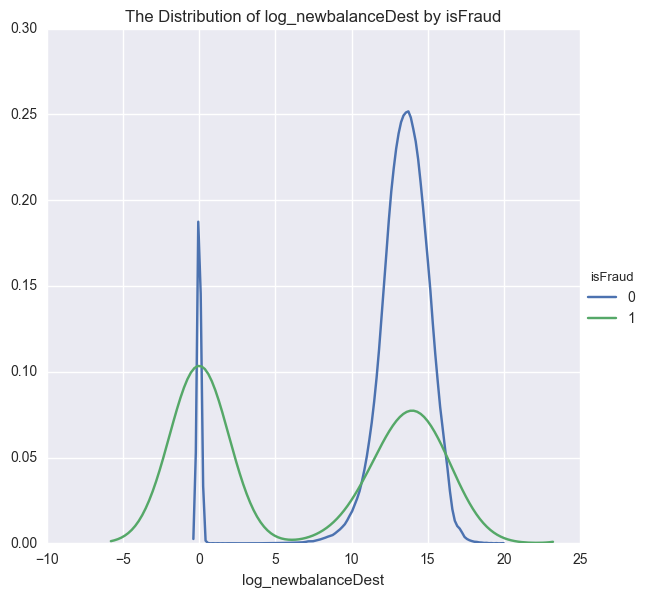

In [34]:
df_ex['log_newbalanceDest'] = df_ex['newbalanceDest'].apply(lambda x: np.log1p(x))

df_ex_c = df_ex.ix[df_ex['nameDest'].apply(lambda x: x[0]) == 'C', :]
sns.FacetGrid(df_ex_c, hue='isFraud', size=6).map(sns.kdeplot, 'log_newbalanceDest').add_legend()
plt.title('The Distribution of log_newbalanceDest by isFraud')

## Get ready for modeling 

I would like to use undersampling to deal with the problem of quite imbalalnced target variable

In [35]:
### Prepare the data for modeling 
num_col = ['amount', 'oldbalanceOrg', 'oldbalanceDest', 'newbalanceDest']
def model_preprocess(df, num_col = []):
    
    ### one-hot encoding
    df_new = pd.get_dummies(df['type'], prefix='type')
    
    df['first_nameDest'] = df['nameDest'].apply(lambda x: x[0])
    df_new = pd.concat([df_new, pd.get_dummies(df['first_nameDest'], prefix='nameDist')], axis=1)
    
    ### numerical variables
    df_new = pd.concat([df_new, df.ix[:, num_col]], axis=1)
    
    for feature in num_col:
        df_new['log_'+feature] = df[feature].apply(lambda x: np.log1p(x))
    
    ### target variable
    df_new['isFraud'] = df['isFraud']
    
    return df_new

df_new = model_preprocess(df, num_col)

In [36]:
df_new.head()

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,nameDist_C,nameDist_M,amount,oldbalanceOrg,oldbalanceDest,newbalanceDest,log_amount,log_oldbalanceOrg,log_oldbalanceDest,log_newbalanceDest,isFraud
0,0,0,0,1,0,0,1,9839.64,170136.0,0.0,0.0,9.194276,12.044359,0.000000,0.0,0
1,0,0,0,1,0,0,1,1864.28,21249.0,0.0,0.0,7.531166,9.964112,0.000000,0.0,0
2,0,0,0,0,1,1,0,181.00,181.0,0.0,0.0,5.204007,5.204007,0.000000,0.0,1
3,0,1,0,0,0,1,0,181.00,181.0,21182.0,0.0,5.204007,5.204007,9.960954,0.0,1
4,0,0,0,1,0,0,1,11668.14,41554.0,0.0,0.0,9.364703,10.634773,0.000000,0.0,0


In [37]:
### under sampling the dataset (use the ratio of 50:50, and I only use 80% of the fraudulent data)

## Fraud
fraud_ind_list = list(df_new['isFraud'][df_new['isFraud'] == 1].index)
np.random.seed(seed)
fraud_sample_ind_list = np.random.choice(fraud_ind_list, int(len(fraud_ind_list)*0.8), replace=False)

ratio = 0.5
nonfraud_ind_list = list(df_new['isFraud'][df_new['isFraud'] != 1].index)
nonfraud_sample_ind_list = np.random.choice(nonfraud_ind_list, int(len(fraud_sample_ind_list)*((1-ratio)/ratio)), replace=False)

In [38]:
train_ind = np.r_[fraud_sample_ind_list, nonfraud_sample_ind_list]
print(len(train_ind))

13140


In [39]:
np.random.shuffle(train_ind)

In [40]:
df_tr = df_new.ix[train_ind, :]

In [41]:
df_tr.index = range(len(df_tr))

In [42]:
df_tr.head()

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,nameDist_C,nameDist_M,amount,oldbalanceOrg,oldbalanceDest,newbalanceDest,log_amount,log_oldbalanceOrg,log_oldbalanceDest,log_newbalanceDest,isFraud
0,0,0,0,0,1,1,0,2388251.16,2388251.16,0.00,0.00,14.686072,14.686072,0.000000,0.000000,1
1,0,0,0,1,0,0,1,615.62,80.00,0.00,0.00,6.424253,4.394449,0.000000,0.000000,0
2,0,0,0,0,1,1,0,98533.36,98533.36,0.00,0.00,11.498161,11.498161,0.000000,0.000000,1
3,0,1,0,0,0,1,0,8991625.83,8991625.83,2195033.03,11186658.86,16.011804,16.011804,14.601708,16.230233,1
4,0,1,0,0,0,1,0,373669.68,504989.00,371909.78,745579.45,12.831130,13.132294,12.826409,13.521918,0


## Modeling

In [43]:
X = df_tr.ix[:, df_tr.columns[:-1]].values
y = df_tr['isFraud'].values

#### How each feature performs

In [44]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500)
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [45]:
ind = np.argsort(np.array(model.feature_importances_))

for i in range(len(ind)):
    print(np.array(df_tr.columns[:-1])[ind][::-1][i], ':  ', np.array(model.feature_importances_)[ind][::-1][i])

log_oldbalanceOrg :   0.166032055399
oldbalanceOrg :   0.157887441155
log_amount :   0.120161825312
amount :   0.115283599694
type_CASH_IN :   0.0798274763467
type_TRANSFER :   0.063006073329
type_CASH_OUT :   0.047337575472
log_newbalanceDest :   0.039350429194
newbalanceDest :   0.0366366323181
nameDist_C :   0.0365747477287
nameDist_M :   0.0351245219764
oldbalanceDest :   0.0350101164397
log_oldbalanceDest :   0.0340882570321
type_PAYMENT :   0.0328206087163
type_DEBIT :   0.000858639885967


#### Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

kf = KFold(5, random_state=seed, shuffle=True)

for fold in kf.split(X):
    model = LogisticRegression()
    model.fit(X[fold[0]], y[fold[0]])
    print(accuracy_score(y[fold[1]], model.predict(X[fold[1]])))

0.649162861492
0.647640791476
0.641933028919
0.637747336377
0.659817351598


#### Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

kf = KFold(5, random_state=seed, shuffle=True)

for fold in kf.split(X):
    model = RandomForestClassifier()
    model.fit(X[fold[0]], y[fold[0]])
    print(accuracy_score(y[fold[1]], model.predict(X[fold[1]])))

0.981735159817
0.977549467275
0.980593607306
0.983637747336
0.985920852359


#### Xgboost

In [141]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

kf = KFold(5, random_state=seed, shuffle=True)

for fold in kf.split(X):
    model = XGBClassifier(n_estimators=150, learning_rate=0.15)
    model.fit(X[fold[0]], y[fold[0]])
    print(accuracy_score(y[fold[1]], model.predict(X[fold[1]])))

0.983637747336
0.982115677321
0.978691019787
0.982876712329
0.985159817352


In [142]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support

kf = KFold(5, random_state=seed, shuffle=True)

threshold = np.arange(0.5, 1, 0.05)

precision = []
recall = []
f1 = []

for th in threshold:
    pre = 0
    rec = 0
    f = 0
    for fold in kf.split(X):
        model = XGBClassifier(n_estimators=150, learning_rate=0.15)
        model.fit(X[fold[0]], y[fold[0]])
        #print(accuracy_score(y[fold[1]], model.predict(X[fold[1]])))
        prediction = model.predict_proba(X[fold[1]])
        ppf_tb = precision_recall_fscore_support(y[fold[1]], prediction[:, 1]>th)
        pre+=ppf_tb[0][1]
        rec+=ppf_tb[1][1]
        f+=ppf_tb[2][1]
    
    precision.append(pre/5)
    recall.append(rec/5)
    f1.append(f/5)

print(threshold)
print(precision)
print(recall)
print(f1)

[ 0.5   0.55  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95]
[0.96907831906347275, 0.97178643522434816, 0.97494343117053983, 0.97784008005135203, 0.98088469042930249, 0.98376344056389409, 0.98626588502164181, 0.9899995779940991, 0.995730079364464, 0.99882147029593293]
[0.9967981399239072, 0.99633952232944978, 0.994968289932326, 0.99420339362423937, 0.99237578204547927, 0.98734580900973423, 0.9725664138866762, 0.93375796060743621, 0.85416696925231028, 0.77242453414841228]
[0.9827341436775161, 0.9839037015077341, 0.98484722803286628, 0.98594673584313175, 0.98658927768481064, 0.98554190756755866, 0.97935186374210548, 0.96102029386589349, 0.91950116434475271, 0.87109144399930971]


#### Neural Network

In [139]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from keras.layers import advanced_activations

np.random.seed(seed)

kf = KFold(5, random_state=seed, shuffle=True)

for fold in kf.split(X):
    model = Sequential()
    model.add(Dense(12, input_dim=len(df_new.columns[:-1]), init='uniform', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, init='uniform', activation='relu'))
    model.add(Dense(4, init='uniform', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, init='uniform', activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X[fold[0]], y[fold[0]], nb_epoch=150, batch_size=32, verbose=0)
    
    print(accuracy_score(y[fold[1]], model.predict_classes(X[fold[1]])))

2464/2628 [===========================>..] - ETA: 0s0.90601217656


## Test the model on the test dataset

#### Process the data

In [209]:
df_test = df_new.ix[np.setdiff1d(np.arange(len(df_new)), train_ind), :]
print(df_test.shape)
df_test.index = range(len(df_test))

(6349480, 16)


In [210]:
X_test = df_test.ix[:, df_test.columns[:-1]].values
y_test = df_test['isFraud'].values

### Test the model

#### Xgboost

In [223]:
### Xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

model_xgb = XGBClassifier(n_estimators=150, learning_rate=0.15)
model_xgb.fit(X, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.15, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [225]:
X_pred_xgb = model_xgb.predict_proba(X_test)

In [226]:
print(classification_report(y_test, X_pred_xgb[:, 1]>0.95))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00   6347837
          1       0.32      0.78      0.46      1643

avg / total       1.00      1.00      1.00   6349480



In [227]:
pd.crosstab(y_test, X_pred_xgb[:, 1]>0.95)

col_0,False,True
row_0,,
0,6345158,2679
1,368,1275


In [228]:
print(classification_report(y_test, X_pred_xgb[:, 1]>0.99))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00   6347837
          1       0.76      0.72      0.74      1643

avg / total       1.00      1.00      1.00   6349480



In [229]:
pd.crosstab(y_test, X_pred_xgb[:, 1]>0.99)

col_0,False,True
row_0,,
0,6347471,366
1,461,1182


In [265]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, th = roc_curve(y_test, X_pred_xgb[:, 1])

In [266]:
score = roc_auc_score(y_test, X_pred_xgb[:, 1], 'weighted')

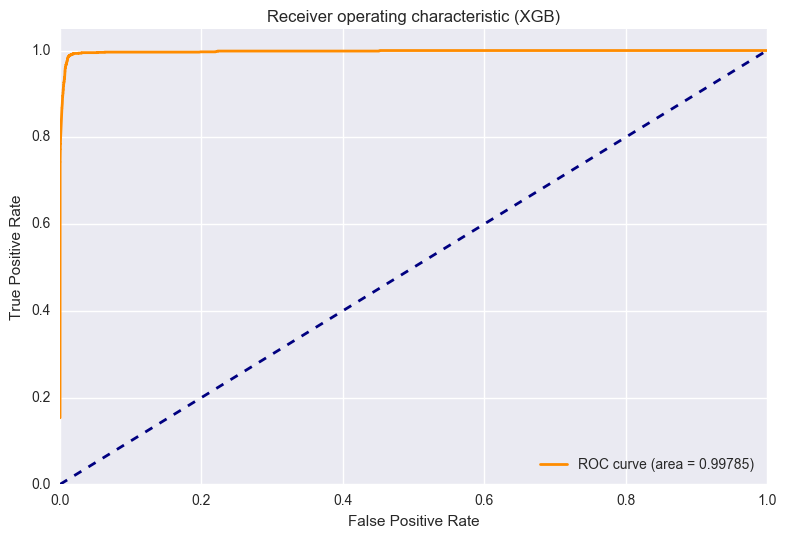

In [267]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.5f)' % score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (XGB)')
plt.legend(loc="lower right")
plt.tight_layout(True)
plt.show()

#### Neural Network

In [222]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

np.random.seed(seed)

model_nn = Sequential()
model_nn.add(Dense(12, input_dim=len(df_new.columns[:-1]), init='uniform', activation='relu'))
model_nn.add(Dropout(0.3))
model_nn.add(Dense(8, init='uniform', activation='relu'))
model_nn.add(Dropout(0.1))
model_nn.add(Dense(1, init='uniform', activation='sigmoid'))

model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_nn.fit(X, y, nb_epoch=150, batch_size=32, verbose=0)

In [235]:
X_pred_nn = model_nn.predict(X_test)

In [247]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, th = roc_curve(y_test, X_pred_nn)

In [268]:
pd.crosstab(y_test, X_pred_nn.flatten()>0.5)

col_0,False,True
row_0,,
0,5137918,1209919
1,22,1621


In [248]:
score = roc_auc_score(y_test, X_pred_nn, 'weighted')

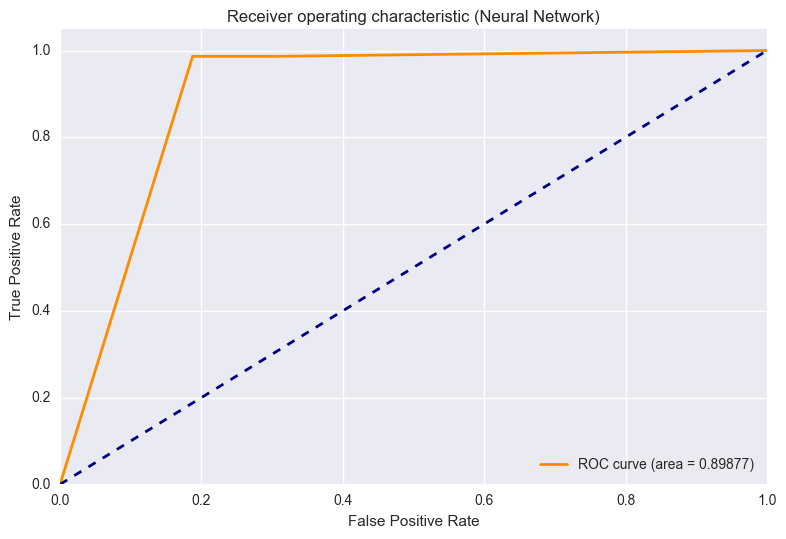

In [264]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.5f)' % score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (Neural Network)')
plt.legend(loc="lower right")
plt.tight_layout(True)
plt.show()